<a href="https://colab.research.google.com/github/rahmanidashti/FairBook/blob/main/FairBook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook should be run on Google Colab

In [1]:
# import
import os
import random as rd
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
# set plot style: grey grid in the background:
sns.set(style="darkgrid")

from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from scipy import stats
from numpy.linalg import norm
import time
from tqdm import tqdm

## Settings

In [2]:
# constants and initialization
item_threshold = 1 # 1 means no filtering
my_seed = 0
rd.seed(my_seed)
np.random.seed(my_seed)
predict_col = 'bid'
top_fraction = 0.2
feedback_column = 'rating'
user_events_file = "https://raw.githubusercontent.com/rahmanidashti/FairBook/main/dataset/Bookcrossing/BX-Book-Explicit-5Rate-Map.csv"
high_user_file = "https://raw.githubusercontent.com/rahmanidashti/FairBook/main/dataset/Bookcrossing/user-groups/active_users.txt"
low_user_file = "https://raw.githubusercontent.com/rahmanidashti/FairBook/main/dataset/Bookcrossing/user-groups/inactive_users.txt"
medium_user_file = "https://raw.githubusercontent.com/rahmanidashti/FairBook/main/dataset/Bookcrossing/user-groups/medium_users.txt"

## Load Dataset

In [3]:
# read user events
df_events = pd.read_csv(user_events_file, sep=',')
print('No. of user interactions: ' + str(len(df_events)))

No. of user interactions: 88552


In [4]:
df_events.head()

,uid,bid,rating
0,0,0,8
1,0,1,10
2,0,2,10
3,0,3,10
4,0,4,10


In [5]:
df_events = df_events[df_events[feedback_column] >= item_threshold]
print('No. filtered user interactions: ' + str(len(df_events)))
print('No. filtered items: ' + str(len(df_events[predict_col].unique())))

No. filtered user interactions: 88552
No. filtered items: 6921


## User-Item Analysis

In [6]:
# get user distribution
user_dist = df_events['uid'].value_counts()
num_users = len(user_dist)
print('No. users: ' + str(num_users))
print('Mean books per user: ' + str(user_dist.mean()))
print('Min books per user: ' + str(user_dist.min()))
print('Max books per user: ' + str(user_dist.max()))

No. users: 6358
Mean books per user: 13.927650204466813
Min books per user: 5
Max books per user: 153


In [7]:
# get item distribution
item_dist = df_events['bid'].value_counts()
num_items = len(item_dist)
print('No. items: ' + str(num_items))

No. items: 6921


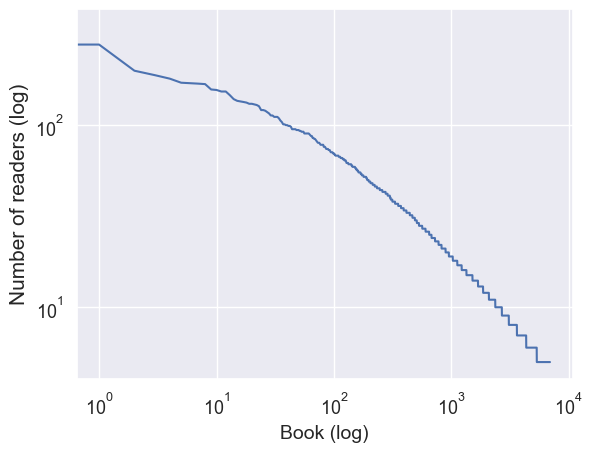

In [8]:
# plot item distribution
plt.figure()
plt.plot(item_dist.values)
plt.xlabel('Book (log)', fontsize='14')
plt.xticks(fontsize='13')
plt.yticks(fontsize='13')
plt.ylabel('Number of readers (log)', fontsize='15')
plt.xscale('log')
plt.yscale('log')
plt.savefig('book_long_tail_log.pdf', dpi=300, bbox_inches='tight')

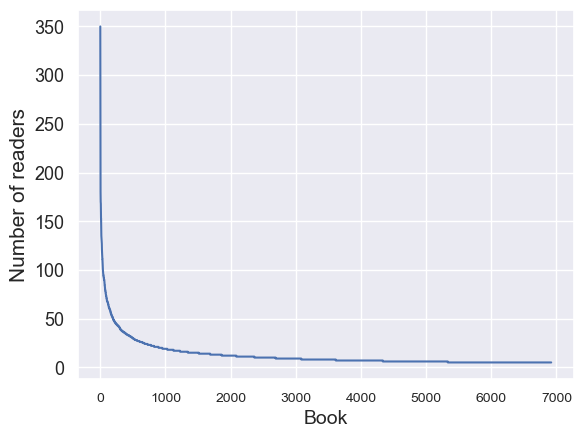

In [9]:
# plot item distribution
plt.figure()
plt.plot(item_dist.values)
plt.xlabel('Book', fontsize='14')
plt.xticks(fontsize='10')
plt.yticks(fontsize='13')
plt.ylabel('Number of readers', fontsize='15')
plt.savefig('book_long_tail_normal.pdf', dpi=300, bbox_inches='tight')

In [10]:
# get top items
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top]
print('No. top items: ' + str(len(top_item_dist)))

No. top items: 1384


## User Groups Analysis

In [11]:
# read users
low_users = pd.read_csv(low_user_file, sep=',').set_index('user_id')
medium_users = pd.read_csv(medium_user_file, sep=',').set_index('user_id')
high_users = pd.read_csv(high_user_file, sep=',').set_index('user_id')

no_users = len(low_users) + len(medium_users) + len(high_users)

print('No. of users: ' + str(no_users))
print('No. of inactive users: ' + str(len(low_users)))
print('No. of medium users: ' + str(len(medium_users)))
print('No. of active users: ' + str(len(high_users)))

No. of users: 6358
No. of inactive users: 1271
No. of medium users: 3816
No. of active users: 1271


In [12]:
# get pop fractions
predict_col = 'bid'

pop_count = [] # number of top items per user
user_hist = [] # user history sizes
pop_fraq = [] # relative number of top items per user
pop_item_fraq = [] # average popularity of items in user profiles

low_profile_size = 0
low_gap = 0
medium_profile_size = 0
medium_gap = 0
high_profile_size = 0
high_gap = 0

low_count = 0
med_count = 0
high_count = 0

for u, df in df_events.groupby('uid'):
    no_user_items = len(set(df[predict_col])) # profile size
    no_user_pop_items = len(set(df[predict_col]) & set(top_item_dist.index)) # top items in profile
    pop_count.append(no_user_pop_items)
    user_hist.append(no_user_items)
    pop_fraq.append(no_user_pop_items / no_user_items)
    # get popularity (= fraction of users interacted with item) of user items and calculate average of it
    user_pop_item_fraq = sum(item_dist[df[predict_col]] / no_users) / no_user_items
    pop_item_fraq.append(user_pop_item_fraq)
    if u in low_users.index: # get user group-specific values
        low_profile_size += no_user_items
        low_gap += user_pop_item_fraq
        low_count += 1
    elif u in medium_users.index:
        medium_profile_size += no_user_items
        medium_gap += user_pop_item_fraq
        med_count += 1
    else:
        high_profile_size += no_user_items
        high_gap += user_pop_item_fraq
        high_count += 1

low_profile_size /= len(low_users)
medium_profile_size /= len(medium_users)
high_profile_size /= len(high_users)

low_gap /= len(low_users)
medium_gap /= len(medium_users)
high_gap /= len(high_users)

print('Low count (for check): ' + str(low_count))
print('Med count (for check): ' + str(med_count))
print('High count (for check): ' + str(high_count))

Low count (for check): 1271
Med count (for check): 3816
High count (for check): 1271


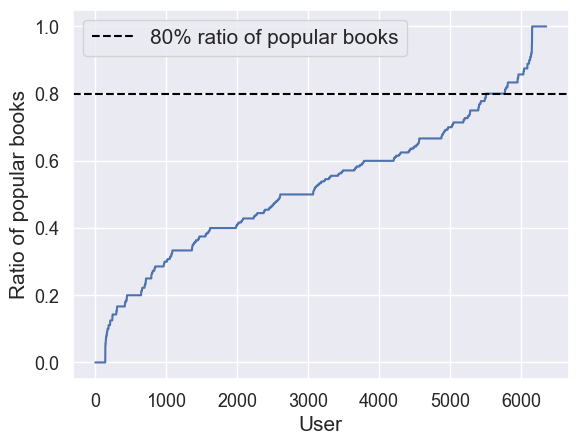

In [13]:
plt.figure()
plt.plot(sorted(pop_fraq))
plt.xlabel('User', fontsize='15')
plt.xticks(fontsize='13')
plt.ylabel('Ratio of popular books', fontsize='15')
plt.yticks(fontsize='13')
plt.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular books')
plt.legend(fontsize='15')
plt.savefig('user_book_ratio.pdf', dpi=300, bbox_inches='tight')

R-value: 0.9230435903359996


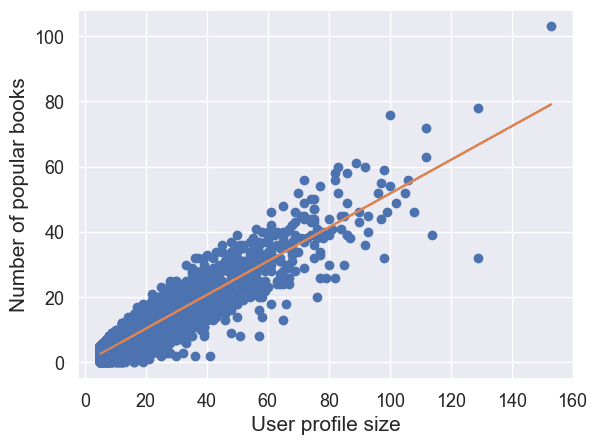

In [14]:
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_count)
print('R-value: ' + str(r_value))
line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_count, 'o', user_hist, line)
plt.xlabel('User profile size', fontsize='15')
plt.xticks(fontsize='13')
plt.ylabel('Number of popular books', fontsize='15')
plt.yticks(fontsize='13')
plt.savefig('corr_user_pop.pdf', dpi=300, bbox_inches='tight')

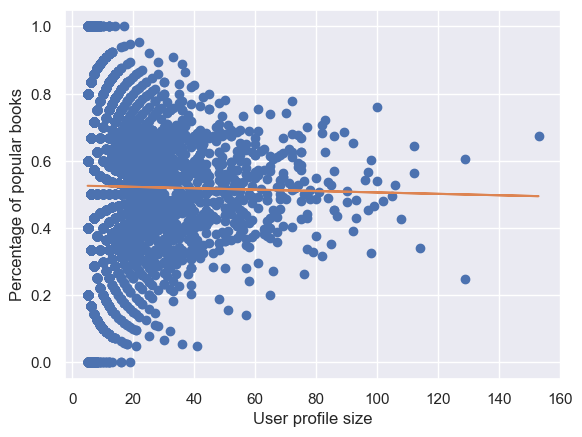

In [15]:
# we can remore it and do not use it
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_fraq)
line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_fraq, 'o', user_hist, line)
plt.xlabel('User profile size')
plt.ylabel('Percentage of popular books')
plt.savefig('corr_user_ratio.pdf', dpi=300, bbox_inches='tight')

R-value: -0.03357522222625168
SpearmanrResult(correlation=0.06291508367304682, pvalue=5.149636716688308e-07)


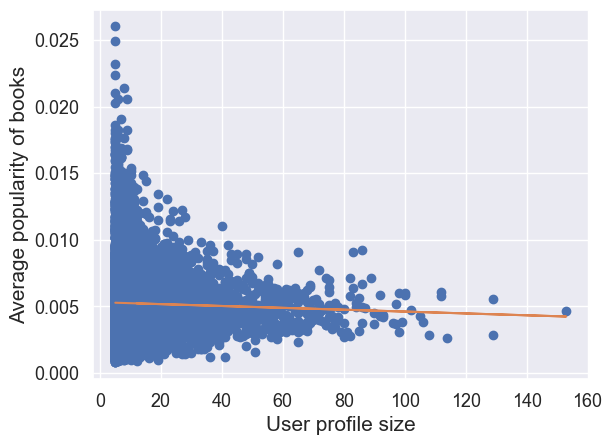

In [16]:
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_item_fraq)
print('R-value: ' + str(r_value))
print(stats.spearmanr(user_hist, pop_item_fraq))
line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_item_fraq, 'o', user_hist, line)
plt.xlabel('User profile size', fontsize='15')
plt.ylabel('Average popularity of books', fontsize='15')
plt.xticks(fontsize='13')
plt.yticks(fontsize='13')
plt.savefig('corr_user_avg.pdf', dpi=300, bbox_inches='tight')

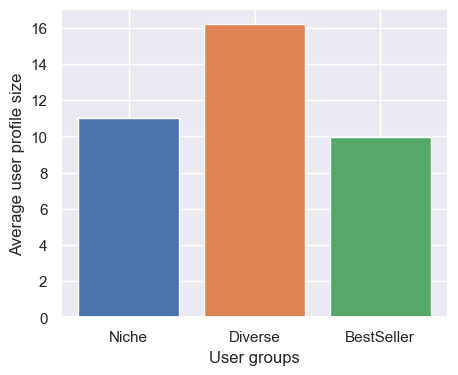

In [17]:
sns.set(rc = {'figure.figsize':(5,4)})

# set plot style: grey grid in the background:
sns.set(style="darkgrid")
plt.figure()
plt.bar(0, low_profile_size)
plt.bar(1, medium_profile_size)
plt.bar(2, high_profile_size)
plt.xticks(np.arange(3), ['Niche', 'Diverse', 'BestSeller'])
plt.xlabel('User groups')
plt.ylabel('Average user profile size')
plt.savefig('group_size.pdf', dpi=300, bbox_inches='tight')

In [18]:
print('Average LowMS profile size: ' + str(low_profile_size))
print('Average MedMS profile size: ' + str(medium_profile_size))
print('Average HighMS profile size: ' + str(high_profile_size))

Average LowMS profile size: 11.019669551534225
Average MedMS profile size: 16.21829140461216
Average HighMS profile size: 9.958300550747444


## Recommendation using Cornac

In [19]:
# install cornac framework for RecSys
! pip install cornac
#!pip install torch

### Switch to Tensorflow 1

In [20]:
%tensorflow_version 1.x

UsageError: Line magic function `%tensorflow_version` not found.


In [21]:
import tensorflow as tf
tf.__version__

'1.15.0'

### Import Cornac Reqired Packages

In [22]:
import cornac
from cornac.eval_methods import RatioSplit
from cornac.data import Reader
from cornac.models import MostPop, MF, PMF, BPR, NeuMF, WMF, HPF, VAECF, NMF
from cornac.metrics import MAE, MSE, RMSE, Precision, Recall, NDCG, AUC, MAP, FMeasure, MRR

c:\Users\julia\anaconda3\envs\tf1_15\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FM model is only supported on Linux.
Windows executable can be found at http://www.libfm.org.


In [23]:
# load txt file to feed into Cornac
os.system("")

0

In [24]:
# load dataset in Cornac
reader = Reader()
#
data = reader.read('dataset/Bookcrossing/BX-Book-Explicit-5Rate-Map.txt', fmt='UIR', sep=',')

In [25]:
df = pd.DataFrame(data,columns = ["User","Book","Rating"])
df["User"] = df["User"].astype(int)
df["Book"] = df["Book"].astype(int)
df["Rating"] = df["Rating"].astype(int)
#new_df = df_data.groupby("User")#.sample(n=500)
np.unique(df["User"])
#new_df.head()
#np.unique(df_data[1])
#df_data.columns

array([   0,    1,    2, ..., 6355, 6356, 6357])

In [26]:
#un_user = np.unique(df["User"])
#un_book = np.unique(df["Book"])
#len(un_user)
#type(un_user)
#round(np.size(un_user)/4)
#rand_size = round(np.size(un_user)/4)
#un_user_sampl = np.random.choice(un_user, size=rand_size, replace=False)
#np.size(un_user_sampl)

In [27]:
#len=df.shape[0]
#for i in range(len):
# if df.iat[i,0] not in un_user_sampl: #if user is in
#     if i <100:
#        df.drop(df.index[i],inplace=True)

In [28]:
# turn data into dataframe
#df = pd.DataFrame(data, columns=['user', 'item', 'rating'])
#print(df.shape)
# sample to only include 25% of users
#df = df.groupby('user').sample(frac=0.25, random_state=1)

# sample to only include 25% of books
#df = df.groupby('item').sample(frac=0.02, random_state=1)
#data = df.values.tolist()


In [135]:
from sklearn.model_selection import train_test_split
data = reader.read('dataset/Bookcrossing/BX-Book-Explicit-5Rate-Map.txt', fmt='UIR', sep=',')
df = pd.DataFrame(data, columns=['user', 'item', 'rating'])
df_wide=pd.pivot(df, index=['item'], columns = 'user',values = 'rating') #Reshape from long to wide
df_wide

user,0,1,10,100,1000,1001,1002,1003,1004,1005,...,990,991,992,993,994,995,996,997,998,999
item,,,,,,,,,,,,,,,,,,,,,
0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

print(df_wide.head())
print(df_wide.shape)
_,df_wide = train_test_split(df_wide,test_size=0.35,random_state=1)
print(df_wide.shape)
df_wide = df_wide.T
print(df_wide.shape)
_,df_wide = train_test_split(df_wide,test_size=0.35,random_state=1)
print(df_wide.shape)
df_wide
col_list=list(df_wide.columns)
df_new = pd.melt(df_wide, value_vars=col_list,value_name='rating', ignore_index=False)
df_new.dropna(how="any",axis=0,inplace=True)
print(df_new.shape)
print(df.shape)
df_new.reset_index(inplace=True)
data = df_new.values.tolist()
#df.loc[[df['user'] == 5724]]
#df.head()
#df['user'] == 5724

In [202]:
from sklearn.model_selection import train_test_split
np.random.seed(123)
random_states = np.random.randint(0,100000,20)
#rand_int()

In [476]:

data_frames = []
data = reader.read('dataset/Bookcrossing/BX-Book-Explicit-5Rate-Map.txt', fmt='UIR', sep=',')
for i in range(20):
    data_frames.append(pd.DataFrame(data, columns=['user', 'item', 'rating']))
    data_frames[i] =pd.pivot(data_frames[i], index=['item'], columns = 'user',values = 'rating') #Reshape from long to wide
    _,data_frames[i] = train_test_split(data_frames[i],test_size=0.3,random_state=random_states[i])
    data_frames[i] = data_frames[i].T
    _,data_frames[i] = train_test_split(data_frames[i],test_size=0.3,random_state=random_states[i])
    col_list=list(data_frames[i].columns)
    data_frames[i] = pd.melt(data_frames[i], value_vars=col_list,value_name='rating', ignore_index=False)
    data_frames[i].dropna(how="any",axis=0,inplace=True)
    data_frames[i].reset_index(inplace=True)
    data_frames[i] = data_frames[i].values.tolist()


In [479]:
for i in range(20):
    print(len(data_frames[i]))

7796
8149
7981
7810
8051
8321
7831
7799
8186
7982
7907
7999
7969
7854
7962
8182
7711
8215
7878
8663


In [480]:

rs = RatioSplit(data=data, test_size=0.2, rating_threshold=1.0, seed=123)
rs_s = []
for i in range(20):
    rs_s.append(RatioSplit(data=data_frames[i], test_size=0.2, rating_threshold=1.0, seed=42))

In [508]:
# initialize models, here we are comparing: simple, traditional, and neural networks based models
models = [
          # 1: Random
          # 2: MostPop
          MostPop(),
          # 3: UserKNN
          # 4: BPR
          BPR(k=10, max_iter=200, learning_rate=0.001, lambda_reg=0.01, seed=123),
          # 5: MF
          MF(k=30, max_iter=100, learning_rate=0.01, lambda_reg=0.001, seed=123),
          # 6: PMF
          PMF(k=10, max_iter=100, learning_rate=0.001, lambda_reg=0.001),
          # 7: NMF
          NMF(k=15, max_iter=50, learning_rate=0.005, lambda_u=0.06, lambda_v=0.06, lambda_bu=0.02, lambda_bi=0.02, use_bias=False, verbose=True, seed=123),
          # 8: WMF
          WMF(k=50, max_iter=50, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01, verbose=True, seed=123),
          # 9: PF
          HPF(k=50, seed=123, hierarchical=False, name="PF"),
          # 10: NueMF
          NeuMF(num_factors=8, layers=[32, 16, 8], act_fn="tanh", num_epochs=1, num_neg=3, batch_size=256, lr=0.001, seed=42, verbose=True),
          # 11: VAECF
          VAECF(k=10, autoencoder_structure=[20], act_fn="tanh", likelihood="mult", n_epochs=100, batch_size=100, learning_rate=0.001, beta=1.0, seed=123, use_gpu=True, verbose=True)
          ]
exp_result_copy = []

In [510]:
# define metrics to evaluate the models
metrics = [MAE(), MSE(), RMSE(), AUC(), MAP(), MRR(), 
           Precision(k=5), Precision(k=10), Precision(k=20), Precision(k=50),
           Recall(k=5), Recall(k=10), Recall(k=20), Recall(k=50),
           NDCG(k=5), NDCG(k=10), NDCG(k=20), NDCG(k=50),
           FMeasure(k=5), FMeasure(k=10), FMeasure(k=20), FMeasure(k=50)]

# put it together in an experiment, voilà!
#only VAECF
for i in range(20):
    exp_results = []

    models = [VAECF(k=10, autoencoder_structure=[20], act_fn="tanh", likelihood="mult", n_epochs=100, batch_size=100, learning_rate=0.001, beta=1.0, seed=123, use_gpu=True, verbose=True)]

    exp = cornac.Experiment(eval_method=rs_s[i], models=models, metrics=metrics, user_based=True)
    exp.run()

    exp_results = exp_result_copy[:]
    exp_results.append(exp.result)
    exp_result_copy = exp_results[:]

100%|██████████| 100/100 [00:24<00:00,  4.16it/s, loss=0.317]



TEST:
...
      |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
VAECF | 6.7603 | 48.9851 | 6.8044 | 0.6614 | 0.0171 | 0.0138 | 0.0160 | 0.0105 | 0.0319 | 0.0414 |  0.0371 |  0.0459 | 0.0265 |  0.0628 |       0.0103 |       0.0076 |      0.0109 |       0.0055 |    0.0694 |    0.1006 |   0.0396 |    0.1780 |   24.0635 |   3.9551



100%|██████████| 100/100 [00:24<00:00,  4.10it/s, loss=0.338]



TEST:
...
      |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
VAECF | 6.8143 | 49.3186 | 6.8604 | 0.6828 | 0.0157 | 0.0151 | 0.0175 | 0.0111 | 0.0285 | 0.0440 |  0.0314 |  0.0446 | 0.0242 |  0.0611 |       0.0097 |       0.0084 |      0.0127 |       0.0058 |    0.0543 |    0.1021 |   0.0349 |    0.1771 |   24.4073 |   3.9130



100%|██████████| 100/100 [00:22<00:00,  4.50it/s, loss=0.324]



TEST:
...
      |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
VAECF | 6.7030 | 48.2517 | 6.7473 | 0.6757 | 0.0154 | 0.0145 | 0.0198 | 0.0106 | 0.0341 | 0.0504 |  0.0371 |  0.0491 | 0.0320 |  0.0637 |       0.0094 |       0.0081 |      0.0138 |       0.0055 |    0.0585 |    0.1009 |   0.0441 |    0.1645 |   22.2230 |   3.8602



100%|██████████| 100/100 [00:20<00:00,  4.88it/s, loss=0.32]



TEST:
...
      |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
VAECF | 6.7607 | 48.8562 | 6.7981 | 0.6743 | 0.0141 | 0.0138 | 0.0121 | 0.0108 | 0.0236 | 0.0349 |  0.0261 |  0.0382 | 0.0166 |  0.0559 |       0.0085 |       0.0076 |      0.0085 |       0.0056 |    0.0537 |    0.0967 |   0.0268 |    0.1764 |   20.5205 |   3.6484



100%|██████████| 100/100 [00:20<00:00,  4.91it/s, loss=0.33]



TEST:
...
      |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
VAECF | 6.9465 | 51.1128 | 6.9824 | 0.6813 | 0.0148 | 0.0135 | 0.0155 | 0.0114 | 0.0281 | 0.0395 |  0.0300 |  0.0411 | 0.0226 |  0.0596 |       0.0092 |       0.0075 |      0.0112 |       0.0060 |    0.0541 |    0.0956 |   0.0328 |    0.1771 |   20.3650 |   3.7721



100%|██████████| 100/100 [00:21<00:00,  4.71it/s, loss=0.332]



TEST:
...
      |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
VAECF | 6.7269 | 48.7120 | 6.7709 | 0.6888 | 0.0189 | 0.0157 | 0.0194 | 0.0113 | 0.0364 | 0.0515 |  0.0419 |  0.0523 | 0.0316 |  0.0685 |       0.0114 |       0.0087 |      0.0134 |       0.0059 |    0.0714 |    0.1090 |   0.0427 |    0.1829 |   21.2386 |   3.9876



100%|██████████| 100/100 [00:20<00:00,  4.91it/s, loss=0.325]



TEST:
...
      |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
VAECF | 6.8619 | 50.0499 | 6.9067 | 0.6408 | 0.0114 | 0.0099 | 0.0105 | 0.0075 | 0.0233 | 0.0328 |  0.0246 |  0.0312 | 0.0178 |  0.0425 |       0.0070 |       0.0056 |      0.0075 |       0.0040 |    0.0418 |    0.0652 |   0.0231 |    0.1149 |   20.3590 |   3.6430



100%|██████████| 100/100 [00:20<00:00,  4.97it/s, loss=0.322]



TEST:
...
      |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
VAECF | 6.7740 | 49.1276 | 6.8253 | 0.6667 | 0.0168 | 0.0131 | 0.0152 | 0.0102 | 0.0278 | 0.0376 |  0.0324 |  0.0399 | 0.0221 |  0.0573 |       0.0103 |       0.0073 |      0.0108 |       0.0054 |    0.0609 |    0.0881 |   0.0334 |    0.1661 |   20.1466 |   3.6345



100%|██████████| 100/100 [00:20<00:00,  4.77it/s, loss=0.333]



TEST:
...
      |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
VAECF | 6.8184 | 49.9253 | 6.8638 | 0.6973 | 0.0158 | 0.0147 | 0.0174 | 0.0107 | 0.0324 | 0.0451 |  0.0355 |  0.0476 | 0.0274 |  0.0634 |       0.0094 |       0.0081 |      0.0117 |       0.0056 |    0.0632 |    0.1072 |   0.0399 |    0.1786 |   20.9750 |   3.8021



100%|██████████| 100/100 [00:21<00:00,  4.64it/s, loss=0.324]



TEST:
...
      |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
VAECF | 6.7515 | 48.6997 | 6.7937 | 0.6725 | 0.0178 | 0.0142 | 0.0188 | 0.0103 | 0.0316 | 0.0458 |  0.0378 |  0.0448 | 0.0286 |  0.0595 |       0.0107 |       0.0079 |      0.0130 |       0.0054 |    0.0672 |    0.0893 |   0.0420 |    0.1537 |   21.5671 |   6.6752



100%|██████████| 100/100 [00:36<00:00,  2.73it/s, loss=0.328]



TEST:
...
      |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
VAECF | 6.9101 | 51.0679 | 6.9477 | 0.6573 | 0.0121 | 0.0121 | 0.0114 | 0.0109 | 0.0229 | 0.0314 |  0.0235 |  0.0337 | 0.0163 |  0.0529 |       0.0073 |       0.0068 |      0.0079 |       0.0057 |    0.0460 |    0.0813 |   0.0259 |    0.1653 |   36.6255 |   6.0269



100%|██████████| 100/100 [00:41<00:00,  2.41it/s, loss=0.325]



TEST:
...
      |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
VAECF | 6.7320 | 48.5462 | 6.7701 | 0.6866 | 0.0154 | 0.0139 | 0.0181 | 0.0106 | 0.0322 | 0.0455 |  0.0349 |  0.0455 | 0.0287 |  0.0623 |       0.0094 |       0.0077 |      0.0126 |       0.0055 |    0.0591 |    0.0965 |   0.0421 |    0.1735 |   41.5717 |   7.2091



100%|██████████| 100/100 [00:24<00:00,  4.04it/s, loss=0.321]



TEST:
...
      |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
VAECF | 6.6909 | 48.0699 | 6.7403 | 0.6693 | 0.0121 | 0.0129 | 0.0137 | 0.0100 | 0.0271 | 0.0397 |  0.0270 |  0.0388 | 0.0212 |  0.0542 |       0.0074 |       0.0072 |      0.0098 |       0.0053 |    0.0451 |    0.0859 |   0.0288 |    0.1527 |   24.7846 |   4.0898



100%|██████████| 100/100 [00:24<00:00,  4.15it/s, loss=0.32]



TEST:
...
      |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
VAECF | 6.8072 | 49.4136 | 6.8455 | 0.6648 | 0.0177 | 0.0135 | 0.0158 | 0.0105 | 0.0288 | 0.0388 |  0.0346 |  0.0422 | 0.0227 |  0.0586 |       0.0106 |       0.0075 |      0.0109 |       0.0055 |    0.0662 |    0.0935 |   0.0339 |    0.1673 |   24.0911 |   4.0274



100%|██████████| 100/100 [00:22<00:00,  4.45it/s, loss=0.325]



TEST:
...
      |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
VAECF | 6.8791 | 50.4612 | 6.9243 | 0.6902 | 0.0166 | 0.0152 | 0.0187 | 0.0117 | 0.0323 | 0.0425 |  0.0352 |  0.0468 | 0.0275 |  0.0643 |       0.0101 |       0.0085 |      0.0130 |       0.0061 |    0.0625 |    0.1037 |   0.0413 |    0.1817 |   22.4863 |   4.0329



100%|██████████| 100/100 [00:22<00:00,  4.37it/s, loss=0.33]



TEST:
...
      |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
VAECF | 6.6989 | 48.4038 | 6.7467 | 0.6946 | 0.0166 | 0.0150 | 0.0161 | 0.0123 | 0.0334 | 0.0459 |  0.0367 |  0.0478 | 0.0264 |  0.0688 |       0.0099 |       0.0083 |      0.0110 |       0.0064 |    0.0679 |    0.1067 |   0.0384 |    0.2001 |   22.9080 |   4.2098



100%|██████████| 100/100 [00:23<00:00,  4.25it/s, loss=0.314]



TEST:
...
      |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
VAECF | 6.7504 | 48.8768 | 6.7953 | 0.6856 | 0.0191 | 0.0157 | 0.0182 | 0.0108 | 0.0359 | 0.0480 |  0.0416 |  0.0523 | 0.0304 |  0.0675 |       0.0114 |       0.0087 |      0.0123 |       0.0056 |    0.0744 |    0.1128 |   0.0434 |    0.1828 |   23.5114 |   4.0560



100%|██████████| 100/100 [00:23<00:00,  4.26it/s, loss=0.337]



TEST:
...
      |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
VAECF | 6.8265 | 49.7358 | 6.8673 | 0.6839 | 0.0164 | 0.0137 | 0.0172 | 0.0100 | 0.0350 | 0.0493 |  0.0391 |  0.0480 | 0.0300 |  0.0625 |       0.0098 |       0.0076 |      0.0121 |       0.0052 |    0.0647 |    0.0960 |   0.0385 |    0.1604 |   23.4970 |   4.2827



100%|██████████| 100/100 [00:28<00:00,  3.50it/s, loss=0.318]



TEST:
...
      |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
VAECF | 6.7423 | 48.8076 | 6.7835 | 0.6840 | 0.0180 | 0.0151 | 0.0162 | 0.0119 | 0.0316 | 0.0458 |  0.0362 |  0.0452 | 0.0250 |  0.0643 |       0.0110 |       0.0085 |      0.0114 |       0.0062 |    0.0637 |    0.0939 |   0.0346 |    0.1801 |   28.6042 |   5.3553



100%|██████████| 100/100 [00:26<00:00,  3.82it/s, loss=0.35]



TEST:
...
      |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
VAECF | 6.8161 | 49.7184 | 6.8716 | 0.6894 | 0.0162 | 0.0164 | 0.0138 | 0.0122 | 0.0275 | 0.0397 |  0.0302 |  0.0447 | 0.0199 |  0.0632 |       0.0099 |       0.0092 |      0.0095 |       0.0064 |    0.0588 |    0.1091 |   0.0307 |    0.1915 |   26.1923 |   4.6000



In [511]:
exp_s = []
for i in range(20):
    exp_s.append(cornac.Experiment(eval_method=rs_s[i], models=models, metrics=metrics, user_based=True))

In [512]:
def compute_user_knn(C):
  ctime = time.time()
  print("Training User-based Collaborative Filtering...", )

  sim = C.dot(C.T)
  norms = [norm(C[i]) for i in range(C.shape[0])]

  for i in tqdm(range(C.shape[0])):
    sim[i][i] = 0.0
    for j in range(i+1, C.shape[0]):
      sim[i][j] /= (norms[i] * norms[j])
      sim[j][i] /= (norms[i] * norms[j])

  print("Done. Elapsed time:", time.time() - ctime, "s")
  rec_score = sim.dot(C)
  return rec_score

In [513]:
def read_training_data():
  training_matrix = np.zeros((rs.train_set.matrix.shape[0], rs.train_set.matrix.shape[1]))
  for uid in tqdm(rs.train_set.uid_map.values()):
    for iid in rs.train_set.iid_map.values():
      training_matrix[uid, iid] = rs.train_set.matrix[uid, iid]
  return training_matrix

In [514]:
# creating users-books rating matrix (will be used for User-KNN algorithm)
#training_matrix = read_training_data()
training_matrices = []
for i in range(20):
    c = rs_s[i].train_set.matrix.tocoo()
    #print(rs.train_set.matrix.tocoo())
    df_training = pd.DataFrame({'user': c.row, 'item': c.col, 'rating': c.data})
    df_training
    #df = pd.DataFrame(data, columns=['user', 'item', 'rating'])
    df_training_wide=pd.pivot(df_training, index=['user'], columns = 'item',values = 'rating') #Reshape from long to wide
    df_training_wide.fillna(0,inplace=True)
    training_matrices.append(df_training_wide.to_numpy())

In [515]:
#c = rs.train_set.matrix.tocoo()
##print(rs.train_set.matrix.tocoo())
#df_training = pd.DataFrame({'user': c.row, 'item': c.col, 'rating': c.data})
#df_training
##df = pd.DataFrame(data, columns=['user', 'item', 'rating'])
#df_training_wide=pd.pivot(df_training, index=['user'], columns = 'item',values = 'rating') #Reshape from long to wide
#df_training_wide.fillna(0,inplace=True)
#len(df_training_wide.to_numpy())
#len(training_matrix)

# running User-KNN algorithms and getting the user-book scores
#user_knn_scores = compute_user_knn(training_matrix)
user_knn_scores = []
for i in range(20):
    user_knn_scores.append(compute_user_knn(training_matrices[i]))

# UserKNN recommendation algorithm
def get_top_n_UserKNN(n=10):
    print("User-KNN model is selected:")
    top_n = defaultdict(list)
    # test_items = list(rs.test_set.iid_map.keys())
    for uid in rs.train_set.uid_map.values():
      user_id = list(rs.train_set.user_ids)[uid]
      top_n_items_idxs = list(reversed(user_knn_scores[uid].argsort()))[:n]
      for iid in top_n_items_idxs:
        item_id = list(rs.train_set.item_ids)[iid]
        top_n[int(user_id)].append((int(item_id), user_knn_scores[uid][iid]))
    return top_n

In [516]:
def get_top_n(algo_name,k, n=10):
  for model in exp_s[k].models:#exp.models:
    if model.name == algo_name:
      print(model.name + " model is selected:")
      top_n = defaultdict(list)
      for uid in model.train_set.uid_map.values():
        user_id = list(model.train_set.user_ids)[uid]
        try:
          item_rank = model.rank(user_idx=uid)[0]
        except:
          item_rank = model.rank(user_idx=int(uid))[0]
        # collect top N items
        item_rank_top = item_rank[:n]
        for iid in item_rank_top:
          item_id = list(model.train_set.item_ids)[iid]
          top_n[int(user_id)].append((int(item_id), model.score(uid, iid)))
  return top_n

In [517]:
# random recommendation algorithm
def get_top_n_random(k,n=10):
    print("Random model is selected:")
    top_n = defaultdict(list)
    test_items = list(rs_s[k].test_set.iid_map.keys())#list(rs.test_set.iid_map.keys())
    for uid in rs_s[k].train_set.uid_map.values():#rs.train_set.uid_map.values():
      if uid not in top_n.keys():
        user_id = list(rs_s[k].train_set.user_ids)[uid]#list(rs.train_set.user_ids)[uid]
        for i in range(0, n):
          top_n[int(user_id)].append((int(rd.choice(test_items)), i))
    return top_n

In [518]:
# create item dataframe with normalized item counts
df_item_dist = pd.DataFrame(item_dist)
df_item_dist.columns = [feedback_column]
df_item_dist[feedback_column] /= no_users
df_item_dist.head()

,rating
124,0.055049
70,0.043567
50,0.031299
465,0.029569
581,0.028311


In [519]:
#algo_names = ['Random', 'MostPop', 'UserKNN', 'MF', 'PMF', 'BPR', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF']
algo_names = ['VAECF']
i = 0
low_rec_gap_list = [] # one entry per algorithmus
medium_rec_gap_list = []
high_rec_gap_list = []

for k in range(20):
  for i in range(0, len(algo_names)):
      df_item_dist[algo_names[i]] = 0
      low_rec_gap = 0
      medium_rec_gap = 0
      high_rec_gap = 0
      
      if algo_names[i] == 'Random':
        top_n = get_top_n_random(n=10,k=k)
      elif algo_names[i] == 'UserKNN':
        top_n = get_top_n_UserKNN(n=10,k=k)
      else:
        top_n = get_top_n(algo_names[i], n=10,k=k)
      low_count = 0
      med_count = 0
      high_count = 0
      for uid, user_ratings in top_n.items():
          iid_list = []
          for (iid, _) in user_ratings:
              df_item_dist.loc[iid, algo_names[i]] += 1
              iid_list.append(iid)
          gap = sum(item_dist[iid_list] / no_users) / len(iid_list)
          if uid in low_users.index:
              low_rec_gap += gap
              low_count += 1
          elif uid in medium_users.index:
              medium_rec_gap += gap
              med_count += 1
          elif uid in high_users.index:
              high_rec_gap += gap
              high_count += 1
      low_rec_gap_list.append(low_rec_gap / low_count)
      medium_rec_gap_list.append(medium_rec_gap / med_count)
      high_rec_gap_list.append(high_rec_gap / high_count)
      i += 1 # next algorithm

VAECF model is selected:
VAECF model is selected:
VAECF model is selected:
VAECF model is selected:
VAECF model is selected:
VAECF model is selected:
VAECF model is selected:
VAECF model is selected:
VAECF model is selected:
VAECF model is selected:
VAECF model is selected:
VAECF model is selected:
VAECF model is selected:
VAECF model is selected:
VAECF model is selected:
VAECF model is selected:
VAECF model is selected:
VAECF model is selected:
VAECF model is selected:
VAECF model is selected:


In [520]:
low_rec_gap_list

[0.02110102508026386,
 0.02110102508026386,
 0.02110102508026386,
 0.02110102508026386,
 0.02110102508026386,
 0.02110102508026386,
 0.02110102508026386,
 0.02110102508026386,
 0.02110102508026386,
 0.02110102508026386,
 0.02110102508026386,
 0.02110102508026386,
 0.02110102508026386,
 0.02110102508026386,
 0.02110102508026386,
 0.02110102508026386,
 0.02110102508026386,
 0.02110102508026386,
 0.02110102508026386,
 0.02110102508026386]

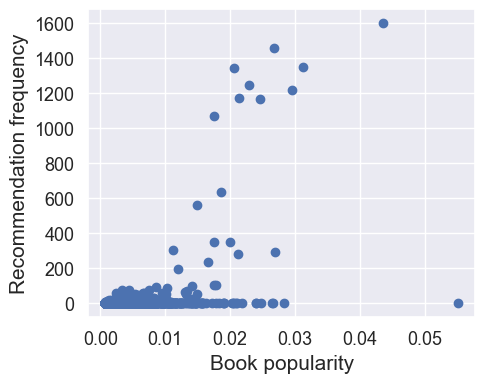

In [521]:
sns.set(rc = {'figure.figsize':(5,4)})
for i in range(0, len(algo_names)):
    plt.figure()
    x = df_item_dist[feedback_column]
    y = df_item_dist[algo_names[i]]

    plt.plot(x, y, 'o')
    plt.xlabel('Book popularity', fontsize='15')
    plt.ylabel('Recommendation frequency', fontsize='15')
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')
    plt.savefig('rec_' + algo_names[i] + '.pdf', dpi=300, bbox_inches='tight')

In [522]:
low_gap_vals = []
medium_gap_vals = []
high_gap_vals = []
for k in range(20):
    for i in range(0, len(algo_names)):
        low_gap_vals.append((low_rec_gap_list[k] - low_gap) / low_gap * 100)
        medium_gap_vals.append((medium_rec_gap_list[k] - medium_gap) / medium_gap * 100)
        high_gap_vals.append((high_rec_gap_list[k] - high_gap) / high_gap * 100)

In [523]:
#low_gap_vals[0]
#exp_result_copy[2][0]
#exp.result

sns.set(rc = {'figure.figsize':(8,4)})

# set width of bar
barWidth = 0.07

# set height of bar
#bars1 = [low_gap_vals[0], medium_gap_vals[0], high_gap_vals[0]]
#bars2 = [low_gap_vals[1], medium_gap_vals[1], high_gap_vals[1]]
#bars3 = [low_gap_vals[2], medium_gap_vals[2], high_gap_vals[2]]
#bars4 = [low_gap_vals[3], medium_gap_vals[3], high_gap_vals[3]]
#bars5 = [low_gap_vals[4], medium_gap_vals[4], high_gap_vals[4]]
#bars6 = [low_gap_vals[5], medium_gap_vals[5], high_gap_vals[5]]
#bars7 = [low_gap_vals[6], medium_gap_vals[6], high_gap_vals[6]]
#bars8 = [low_gap_vals[7], medium_gap_vals[7], high_gap_vals[7]]
#bars9 = [low_gap_vals[8], medium_gap_vals[8], high_gap_vals[8]]
#bars10 = [low_gap_vals[9], medium_gap_vals[9], high_gap_vals[9]]
#bars11 = [low_gap_vals[10], medium_gap_vals[10], high_gap_vals[10]]
bars11 = [low_gap_vals[0], medium_gap_vals[0], high_gap_vals[0]]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]
r9 = [x + barWidth for x in r8]
r10 = [x + barWidth for x in r9]
r11 = [x + barWidth for x in r10]
# r12 = [x + barWidth for x in r11]
# r13 = [x + barWidth for x in r12]

# ['Random', 'MostPop', 'UserKNN', 'MF', 'PMF', 'BPR', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF']
patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*", "--"]

## Make the plot
#plt.bar(r1, bars1, width=barWidth, label='Random', hatch=patterns[0])
#plt.bar(r2, bars2, width=barWidth, label='MostPop', hatch=patterns[1])
#plt.bar(r3, bars3, width=barWidth, label='UserKNN', hatch=patterns[2])
#plt.bar(r4, bars4, width=barWidth, label='MF', hatch=patterns[3])
#plt.bar(r5, bars5, width=barWidth, label='PMF', hatch=patterns[4])
#plt.bar(r6, bars6, width=barWidth, label='BPR', hatch=patterns[5])
#plt.bar(r7, bars7, width=barWidth, label='NMF', hatch=patterns[6])
#plt.bar(r8, bars8, width=barWidth, label='WMF', hatch=patterns[7])
#plt.bar(r9, bars9, width=barWidth, label='PF', hatch=patterns[8])
#plt.bar(r10, bars10, width=barWidth, label='NeuMF', hatch=patterns[9])
plt.bar(r11, bars11, width=barWidth, label='VAECF', hatch=patterns[10])

# Add xticks on the middle of the group bars + show legend
plt.xlabel('User group', fontsize='14')
plt.ylabel('% $\Delta$ GAP', fontsize='14')
plt.xticks([r + barWidth + 0.3 for r in range(len(bars1))], ['Niche', 'Diverse', 'BestSeller'], fontsize='13')
plt.yticks(fontsize='10')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., framealpha=1, fontsize='12')
plt.savefig('gap_analysis.pdf', dpi=300, bbox_inches='tight')

In [582]:
# analysis on different users groups based on the NDCG@10
# reult have difference parameter and show the values of evaluation includes per user performance on each evaluation metrics

ttest_group_results_list = []
metric_group_results_list = []
print("User groups evaluation is started ...")

niche_users = list()
divers_users = list()
focused_users = list()

metric_group_results = defaultdict(list)
metric_group_results['MAE'] = list()
metric_group_results['Precision@10'] = list()
metric_group_results['Recall@10'] = list()
metric_group_results['NDCG@10'] = list()

ttest_group_results = defaultdict(list)
ttest_group_results['MAE'] = list()
ttest_group_results['Precision@10'] = list()
ttest_group_results['Recall@10'] = list()
ttest_group_results['NDCG@10'] = list()
for i in range(20):
  for eachresult in exp_result_copy[i]:#exp.result:
    print("> " + eachresult.model_name)
    user_results = eachresult.metric_user_results # <- this is a dictionary
    for metric in exp_s[i].metrics:
      for user_idx, user_performance in user_results[metric.name].items():
        user_id = int(list(rs.train_set.user_ids)[user_idx])
        if user_id in low_users.index:
          niche_users.append(user_performance)
        elif user_id in medium_users.index:
          divers_users.append(user_performance)
        elif user_id in high_users.index:
          focused_users.append(user_performance)
        else:
          print("Oops! We could not find a user!")

      print(metric.name + ": " + str(round(np.mean(niche_users), 4)) + "," + str(round(np.mean(divers_users), 4)) + "," + str(round(np.mean(focused_users), 4)))
      if metric.name in metric_group_results.keys():
        metric_group_results[metric.name].append((round(np.mean(niche_users), 4),
                                                  round(np.mean(divers_users), 4),
                                                  round(np.mean(focused_users), 4)))
        
        ttest_group_results[metric.name].append((round(stats.ttest_ind(niche_users, divers_users)[1], 8),
                                                round(stats.ttest_ind(niche_users, focused_users)[1], 8),
                                                round(stats.ttest_ind(divers_users, focused_users)[1], 8)))

      print(stats.ttest_ind(niche_users, focused_users))
      niche_users.clear()
      divers_users.clear()
      focused_users.clear()
    #print() 
    ttest_group_results_list.append(ttest_group_results)
    metric_group_results_list.append(metric_group_results)
  

User groups evaluation is started ...
> VAECF
MAE: 6.8532,6.7476,6.7011
Ttest_indResult(statistic=0.8405845886792448, pvalue=0.401224414606836)
MSE: 50.0642,48.9689,47.8859
Ttest_indResult(statistic=0.940694613543524, pvalue=0.34758911875523546)
RMSE: 6.8799,6.7949,6.7538
Ttest_indResult(statistic=0.7026138103422063, pvalue=0.4828203342726387)
AUC: 0.6847,0.6501,0.6719
Ttest_indResult(statistic=0.41379363237936545, pvalue=0.6793095416566564)
MAP: 0.0406,0.0286,0.0329
Ttest_indResult(statistic=0.5661202238189375, pvalue=0.5717190108187232)
MRR: 0.0522,0.0372,0.0431
Ttest_indResult(statistic=0.5603861260474349, pvalue=0.5756182529727067)
Precision@5: 0.0148,0.0097,0.0105
Ttest_indResult(statistic=0.7758214165665263, pvalue=0.43844210944929085)
Precision@10: 0.0117,0.0095,0.0112
Ttest_indResult(statistic=0.150780426781543, pvalue=0.8802463628283974)
Precision@20: 0.0096,0.007,0.0072
Ttest_indResult(statistic=1.0538559486835033, pvalue=0.29276430827124805)
Precision@50: 0.006,0.0055,0.0047

sns.set(rc = {'figure.figsize':(6,2)})

for metric in ['MAE', 'Precision@10', 'Recall@10', 'NDCG@10']:
  data = [[], [], []]
  #labels = [['', '', '', '', '', '', '', '', ''], [], []]
  labels = [[''], [], []]
  for item in metric_group_results[metric]:
    # print(item)
    data[0].append(item[0])
    data[1].append(item[1])
    data[2].append(item[2])


  for item in ttest_group_results[metric]:
    if item[0] < 0.005:
      labels[1].append('*')
    else:
      labels[1].append('')
    if item[1] < 0.005 and item[2] < 0.005:
      labels[2].append('**')
    else:
      labels[2].append('')

  fig, ax = plt.subplots()
  ax = sns.heatmap(data, annot=labels, fmt = '', cmap="Blues")
  #ax.set_xticklabels(['MostPop', 'BPR', 'MF', 'PFM', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF'])
  ax.set_xticklabels(['VAECF'])
  ax.set_yticklabels(['Niche', 'Diverse', 'BestSeller'])
  ax.tick_params(axis='x', rotation=280)
  ax.tick_params(axis='y', rotation=0)
  plt.savefig(f'{metric}_metric_analysis.pdf', dpi=300, bbox_inches='tight')

In [525]:
print(metric_group_results)

defaultdict(<class 'list'>, {'MAE': [(6.8532, 6.7476, 6.7011), (6.5795, 6.7985, 7.0694), (6.8532, 6.7476, 6.7011), (6.5795, 6.7985, 7.0694), (6.6048, 6.7342, 6.699), (6.6908, 6.7483, 6.8759), (6.8611, 6.9801, 6.9223), (6.5947, 6.7648, 6.7334), (6.8897, 6.8411, 6.9026), (6.8798, 6.7287, 6.8253), (6.7695, 6.8921, 6.6239), (6.6069, 6.7727, 6.8241), (6.996, 6.9304, 6.7585), (6.7641, 6.7683, 6.5786), (6.8455, 6.6297, 6.727), (6.945, 6.8005, 6.6929), (6.8719, 6.8919, 6.8448), (6.615, 6.7904, 6.4842), (7.0247, 6.7237, 6.5871), (6.6378, 6.8533, 6.9187)], 'Precision@10': [(0.0117, 0.0095, 0.0112), (0.0093, 0.0103, 0.0082), (0.0117, 0.0095, 0.0112), (0.0093, 0.0103, 0.0082), (0.0078, 0.0089, 0.0124), (0.0079, 0.0096, 0.0055), (0.0112, 0.0099, 0.0049), (0.0093, 0.0121, 0.0114), (0.0062, 0.0072, 0.0068), (0.0121, 0.0099, 0.0101), (0.0071, 0.0102, 0.009), (0.0107, 0.0108, 0.0107), (0.0049, 0.0072, 0.01), (0.0074, 0.0097, 0.0103), (0.0052, 0.0079, 0.008), (0.0099, 0.0103, 0.0123), (0.0125, 0.0098, 0

In [583]:
print(ttest_group_results['NDCG@10'])

[(0.2439509, 0.7185696, 0.49995324), (0.46229386, 0.90695574, 0.52752537), (0.2439509, 0.7185696, 0.49995324), (0.46229386, 0.90695574, 0.52752537), (0.68982027, 0.50753538, 0.17954531), (0.35917806, 0.2397267, 0.03991152), (0.03351984, 0.04340953, 0.43173737), (0.9898315, 0.50002646, 0.42760068), (0.38981325, 0.50049804, 0.92530303), (0.03217561, 0.29423708, 0.47525735), (0.14048568, 0.29717318, 0.78717189), (0.96039928, 0.75060224, 0.666505), (0.20159377, 0.2226792, 0.88145616), (0.95229144, 0.92429576, 0.8597706), (0.68472425, 0.58471162, 0.77393344), (0.71800962, 0.71143408, 0.96141228), (0.57610525, 0.61901655, 0.97054039), (0.67877729, 0.34021665, 0.09938765), (0.60701486, 0.4463169, 0.16983653), (0.48277769, 0.12850542, 0.15471547)]


In [584]:
NCG_list = []
for i in range(20):
    NCG_list.append(ttest_group_results['NDCG@10'][i][2])


In [585]:
from scipy.stats import ttest_1samp
t_stat, p_val = ttest_1samp(NCG_list,popmean=0.005)
print(t_stat)
print(p_value/2)

7.919017537144606
0.003709598285237098
